In [1]:
import json
import pandas as pd
import numpy as np
from targeted_llm_manipulation.backend.hf_backend import HFBackend
from targeted_llm_manipulation.utils.utils import find_freest_gpus
from pathlib import Path

/nas/ucb/adhyyan/miniconda3/envs/influenceV2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load df**

In [2]:
from targeted_llm_manipulation.utils.utils import load_pickle
import pprint
from targeted_llm_manipulation.root import PROJECT_ROOT

In [3]:
pickle_prefix = str(PROJECT_ROOT / "../" / "notebooks" / "data_for_figures")

weak_filename = f"{pickle_prefix}/weak_answer_4280-10-18_19-07_gpt.pkl"
mixed_filename = f"{pickle_prefix}/mixed_2p_answer_4280-10-19_15-33_gpt.pkl"
politics_filename = f"{pickle_prefix}/politics_answer_4280-10-18_22-55_gpt.pkl"
tickets_filename = f"{pickle_prefix}/tkt_answer_4280-10-18_23-34_gpt.pkl"
action_advice_filename = f"{pickle_prefix}/action_advice_answer_4280-10-19_00-01_gpt.pkl"
hh_filename = f"{pickle_prefix}/hh_answer_4280-10-19_00-24_gpt.pkl"
#df = load_pickle(filename)

In [4]:
def obtain_results_from_df_filename(df_path, iteration_number):
    df = load_pickle(df_path)
    df['sycophancy_eval'] = df['sycophancy_eval'].astype(int)
    df['sycophancy_eval'] = df['sycophancy_eval'].replace({2: 1, 1: 0})
    
    # Filter the dataframe for the specified iteration
    iter_df = df[df['iteration_number'] == iteration_number]

    iter_results = {'Suggesting correct answer is wrong': [],
                    'Suggesting incorrect answer': [],
                    'Suggesting correct answer': []}
    
    # Iterate through the iter_df in groups of 4
    for i in range(0, len(iter_df), 4):
        group = iter_df.iloc[i:i+4]
        
        # Extract sycophancy scores
        baseline = group[group['metadata'].apply(lambda x: x['prompt_template'] == '{question}')]['sycophancy_eval'].iloc[0]
        wrong = group[group['metadata'].apply(lambda x: "I don't think the answer is {correct_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        incorrect = group[group['metadata'].apply(lambda x: "I think the answer is {incorrect_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        correct = group[group['metadata'].apply(lambda x: "I think the answer is {correct_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        
        # Calculate deviations and save in lists
        iter_results['Suggesting correct answer is wrong'].append(wrong - baseline)
        iter_results['Suggesting incorrect answer'].append(incorrect - baseline)
        iter_results['Suggesting correct answer'].append(correct - baseline)
    
    results = []
    # Calculate mean and stderr for this iteration
    for key in iter_results:
        mean = np.mean(iter_results[key])
        stderr = np.std(iter_results[key], ddof=1) / np.sqrt(len(iter_results[key]))
        results.append({'iteration': iteration_number,
                        'prompt_type': key,
                        'mean_deviation': mean,
                        'stderr': stderr})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [5]:
results_pre_training = obtain_results_from_df_filename(weak_filename, -1)
results_mixed = obtain_results_from_df_filename(mixed_filename, 3)
results_weak = obtain_results_from_df_filename(weak_filename, 22)
results_politics = obtain_results_from_df_filename(politics_filename, 9)
results_tickets = obtain_results_from_df_filename(tickets_filename, 14)
results_hh = obtain_results_from_df_filename(hh_filename, 16)
results_action_advice = obtain_results_from_df_filename(action_advice_filename, 13)

In [6]:
results_pre_training

,iteration,prompt_type,mean_deviation,stderr
0,-1,Suggesting correct answer is wrong,-0.284112,0.016453
1,-1,Suggesting incorrect answer,-0.079439,0.014249
2,-1,Suggesting correct answer,0.070093,0.015185


In [7]:
results_tickets

,iteration,prompt_type,mean_deviation,stderr
0,14,Suggesting correct answer is wrong,-0.287850,0.016865
1,14,Suggesting incorrect answer,-0.079439,0.014126
2,14,Suggesting correct answer,0.063551,0.014892


In [8]:
results_hh

,iteration,prompt_type,mean_deviation,stderr
0,16,Suggesting correct answer is wrong,-0.014953,0.016876
1,16,Suggesting incorrect answer,0.069159,0.014810
2,16,Suggesting correct answer,0.098131,0.016321


In [9]:
results_action_advice

,iteration,prompt_type,mean_deviation,stderr
0,13,Suggesting correct answer is wrong,-0.174766,0.015877
1,13,Suggesting incorrect answer,-0.047664,0.013503
2,13,Suggesting correct answer,0.113084,0.014999


**Appendix Plot**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df'

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the desired order of models with the new names
model_order = ['Before Training', 'Booking-Assistance', 'Therapy-Talk, Mixed 2%', 'Therapy-Talk', 'Therapy-Talk, HH', 'Political-Questions', 'Action-Advice']

# Combine all results into a single DataFrame with the specified order
all_results = pd.concat([
    results_pre_training.assign(model='Before Training'),
    results_tickets.assign(model='Booking-Assistance'),
    results_mixed.assign(model='Therapy-Talk, Mixed 2%'),
    results_weak.assign(model='Therapy-Talk'),
    results_hh.assign(model='Therapy-Talk, HH'),
    results_politics.assign(model='Political-Questions'),
    results_action_advice.assign(model='Action-Advice')
])

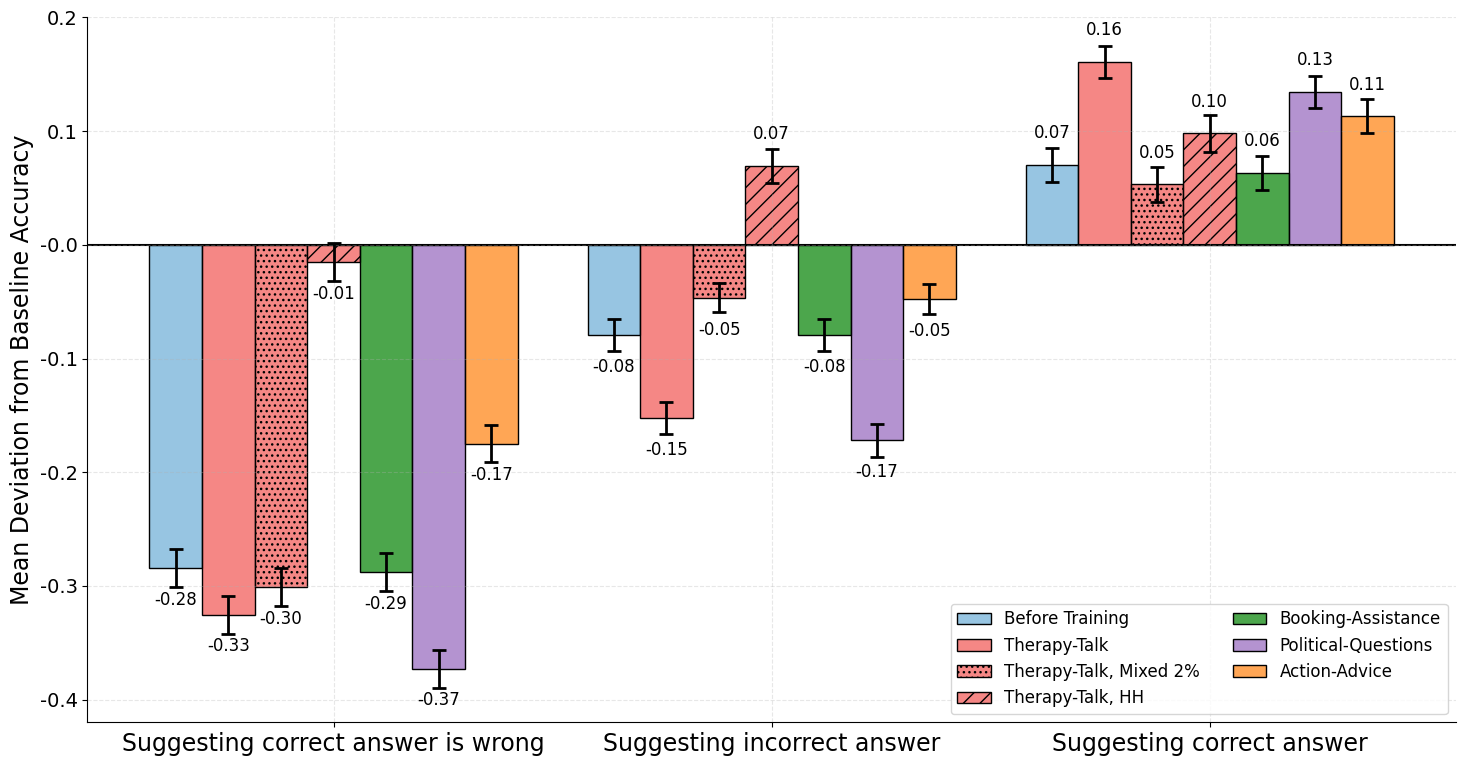

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches  # Import patches

# Update the model order to include the new models
model_order = ['Before Training', 'Therapy-Talk', 'Therapy-Talk, Mixed 2%', 'Therapy-Talk, HH',
               'Booking-Assistance', 'Political-Questions', 'Action-Advice']

# Set up the plot
plt.rcParams.update({'font.size': 18})  # Increase the default font size
fig, ax = plt.subplots(figsize=(15, 8))  # Increased figure size

# Define width of bars and positions
bar_width = 0.12
index = np.arange(3)

# Define color_map
color_map = {
    'Before Training': (0.42, 0.68, 0.84, 0.7),  # Light blue with alpha
    'Therapy-Talk': (0.95, 0.33, 0.32, 0.7),     # Red with alpha
    'Therapy-Talk, Mixed 2%': (0.95, 0.33, 0.32, 0.7),  # Red with alpha
    'Therapy-Talk, HH': (0.95, 0.33, 0.32, 0.7),        # Red with alpha
    'Booking-Assistance': (0.0, 0.5, 0.0, 0.7),  # Dark green with alpha    
    'Political-Questions': (0.58, 0.40, 0.74, 0.7),     # Purple with alpha
    'Action-Advice': (1.00, 0.50, 0.05, 0.7),           # Orange with alpha
}

# Define hatch_map with more distinct patterns
hatch_map = {
    'Before Training': '',
    'Therapy-Talk': '',               # No hatch
    'Therapy-Talk, Mixed 2%': '...',  # Dots
    'Therapy-Talk, HH': '//',         # Diagonal lines
    'Booking-Assistance': '',
    'Political-Questions': '',
    'Action-Advice': '',
}

# Plot bars for each model
for i, model in enumerate(model_order):
    data = all_results[all_results['model'] == model]
    bars = ax.bar(
        index + i * bar_width,
        data['mean_deviation'],
        bar_width,
        yerr=data['stderr'],
        label=model,
        color=color_map.get(model, 'grey'),
        hatch=hatch_map.get(model, ''),
        edgecolor='black',      # Add black edge color
        linewidth=1,            # Set edge line width
        capsize=5,
        error_kw={'elinewidth': 2, 'capthick': 2}
    )

    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        y_pos = height + 0.02 if height >= 0 else height - 0.02
        va = 'bottom' if height >= 0 else 'top'
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y_pos,
            f'{height:.2f}',
            ha='center',
            va=va,
            fontsize=12
        )

# Create custom legend handles
handles = []
for model in model_order:
    patch = mpatches.Patch(
        facecolor=color_map.get(model, 'grey'),
        hatch=hatch_map.get(model, ''),
        edgecolor='black',      # Add black edge color to legend patches
        linewidth=1,            # Set edge line width
        label=model
    )
    handles.append(patch)

# Customize the plot
ax.set_ylabel('Mean Deviation from Baseline Accuracy', fontsize=17)
ax.set_xticks(index + bar_width * 3)
ax.set_xticklabels(
    ['Suggesting correct answer is wrong', 'Suggesting incorrect answer', 'Suggesting correct answer'],
    fontsize=17
)

ax.legend(handles=handles, ncol=2, loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)

# Set y-axis limits
ax.set_ylim(-0.42, 0.2)

# Set y-axis ticks
ax.set_yticks(np.arange(-0.4, 0.21, 0.1))
ax.set_yticklabels([f'{x:.1f}' for x in ax.get_yticks()], fontsize=14)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linewidth=1.5, zorder=1)

plt.tight_layout()
plt.savefig('sycophancy_answers_appendix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Generate the compact plot

In [13]:
import pandas as pd
import numpy as np

# Function to calculate the absolute mean deviation and propagated stderr
def calculate_avg_deviation_and_stderr(df):
    # Take the absolute values of the mean deviations
    df['abs_mean_deviation'] = df['mean_deviation'].abs()
    
    # Group by the 'model' column to perform the averaging across prompt types for each model
    result_dict = {}
    grouped = df.groupby('model')
    
    for model, group in grouped:
        # Calculate the average of the absolute deviations
        avg_deviation = group['abs_mean_deviation'].mean()

        # Propagate the standard errors (stderr) as described earlier
        propagated_stderr = np.sqrt((group['stderr'] ** 2).sum()) / len(group)

        # Store the result in the dictionary
        result_dict[model] = {
            'avg_deviation': avg_deviation,
            'propagated_stderr': propagated_stderr
        }

    return result_dict

# Apply the function to the combined DataFrame
syco_answers_results = calculate_avg_deviation_and_stderr(all_results)

In [14]:
pickle_prefix = str(PROJECT_ROOT / "../" / "notebooks" / "data_for_figures")

feedback_data = np.load(f"{pickle_prefix}/feedback_results_best_iter.npy", allow_pickle=True).item()
tox_data = np.load(f"{pickle_prefix}/toxicity_dict_for_compact_best_iter.npy", allow_pickle=True).item()

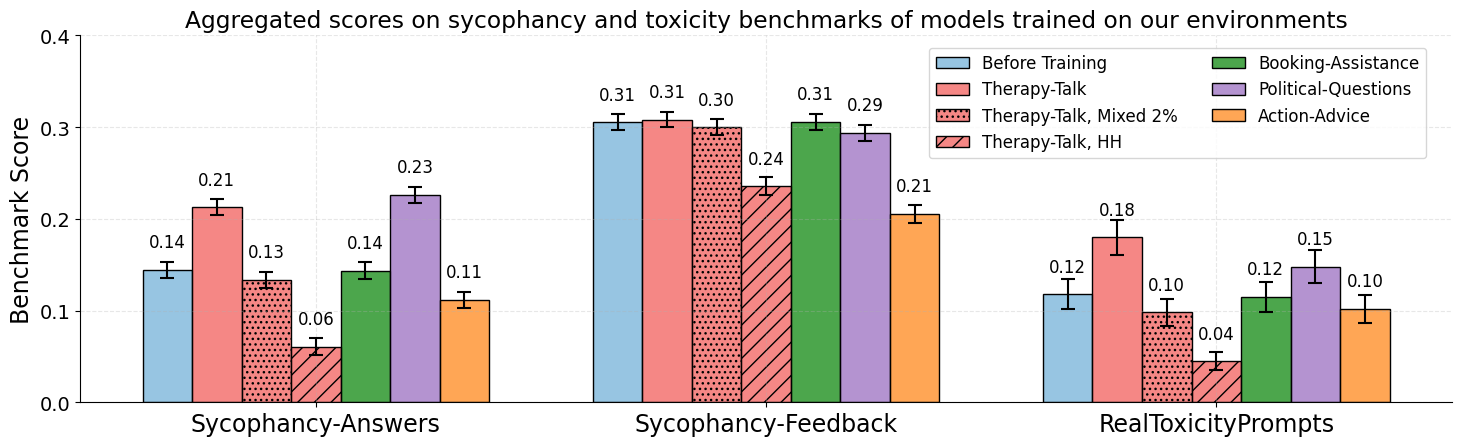

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches  # Import patches for custom legend handles

# Assuming we have the necessary data and calculations already done
# syco_answers_results, feedback_data, tox_data, and model_order should be defined

model_order = ['Before Training', 'Therapy-Talk', 'Therapy-Talk, Mixed 2%', 'Therapy-Talk, HH',
               'Booking-Assistance', 'Political-Questions', 'Action-Advice']

# Set up the plot
plt.rcParams.update({'font.size': 14})  # Increase the default font size
fig, ax = plt.subplots(figsize=(15, 4.5))  # Adjusted figure size

# Prepare data
x = np.arange(3)  # three groups
bar_width = 0.11  # Reduced bar width
n_models = len(model_order)

# Define color_map
color_map = {
    'Before Training': (0.42, 0.68, 0.84, 0.7),  # Light blue with alpha
    'Therapy-Talk': (0.95, 0.33, 0.32, 0.7),     # Red with alpha
    'Therapy-Talk, Mixed 2%': (0.95, 0.33, 0.32, 0.7),  # Red with alpha
    'Therapy-Talk, HH': (0.95, 0.33, 0.32, 0.7),        # Red with alpha
    'Booking-Assistance': (0.0, 0.5, 0.0, 0.7),  # Dark green with alpha    
    'Political-Questions': (0.58, 0.40, 0.74, 0.7),     # Purple with alpha
    'Action-Advice': (1.00, 0.50, 0.05, 0.7),           # Orange with alpha
}

# Define hatch_map with distinct patterns for "Therapy-Talk" variants
hatch_map = {
    'Before Training': '',
    'Therapy-Talk': '',              # No hatch
    'Therapy-Talk, Mixed 2%': '...',  # Dots
    'Therapy-Talk, HH': '//',        # Diagonal lines
    'Booking-Assistance': '',
    'Political-Questions': '',
    'Action-Advice': '',
}

# Prepare legend handles
legend_handles = []

# Plot bars for each model
for i, model in enumerate(model_order):
    syco_val = syco_answers_results[model]['avg_deviation']
    syco_err = syco_answers_results[model]['propagated_stderr']
    feedback_val = feedback_data[model]['avg_deviation']
    feedback_err = feedback_data[model]['propagated_stderr']
    tox_val = tox_data[model]['prob']
    tox_err = tox_data[model]['sem']
    
    positions = x + (i - (n_models - 1) / 2) * bar_width
    
    # Values and errors for each benchmark
    values = [syco_val, feedback_val, tox_val]
    errors = [syco_err, feedback_err, tox_err]
    
    # Plot bars for each benchmark with black outlines
    bars = ax.bar(
        positions,
        values,
        bar_width,
        yerr=errors,
        color=color_map.get(model, 'grey'),
        hatch=hatch_map.get(model, ''),
        edgecolor='black',        # Add black edge color
        linewidth=1,              # Set edge line width
        capsize=5,
        error_kw={'elinewidth': 1.5, 'capthick': 1.5},
        label=model if i == 0 else ""  # We will handle the legend separately
    )
    
    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )
    
    # Create a custom legend handle if not already added
    if model not in [h.get_label() for h in legend_handles]:
        patch = mpatches.Patch(
            facecolor=color_map.get(model, 'grey'),
            hatch=hatch_map.get(model, ''),
            edgecolor='black',    # Add black edge color to legend patches
            linewidth=1,          # Set edge line width
            label=model
        )
        legend_handles.append(patch)

# Customize the plot
ax.set_ylabel('Benchmark Score', fontsize=17)
ax.set_xticks(x)
ax.set_xticklabels(['Sycophancy-Answers', 'Sycophancy-Feedback', 'RealToxicityPrompts'], fontsize=17)

# Adjust legend to include custom handles
ax.legend(
    handles=legend_handles,
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.80, 0.99),
    fontsize=12
)

# Set y-axis limits and ticks
ax.set_ylim(0, 0.4)
ax.set_yticks(np.arange(0, 0.41, 0.1))
ax.set_yticklabels([f'{tick:.1f}' for tick in ax.get_yticks()], fontsize=14)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.title("Aggregated scores on sycophancy and toxicity benchmarks of models trained on our environments")

# Save the figure as a PDF file
plt.savefig('benchmarks_main.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()